<a href="https://colab.research.google.com/github/CodingWeeb-Gaurav/Bitcoin-Prediction/blob/main/LSTM1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Necessary Libraries

In [ ]:
# First we will import the necessary Libraries
import os
import pandas as pd
import numpy as np
import math
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import warnings
# For Evalution we will use these libraries

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

# For model building we will use these libraries

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM


# For PLotting we will use these libraries

import matplotlib.pyplot as plt
from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots



Read the CSV Files of price of bitcoin and number of tweets

In [ ]:
mainprice=pd.read_csv('/content/sample_data/BTC-USD.csv')
maintw=pd.read_csv('/content/sample_data/BTC_Tweets.csv')

# New section

The number of tweets in had string datatype and some values were null, so changed them to proper date datatype

In [ ]:
maintw.head()


,Date,Tweets
0,9/4/2014,8193
1,10/4/2014,15039
2,11/4/2014,14907
3,12/4/2014,7582
4,13/4/2014,10674


In [ ]:
# Convert 'Date' to datetime
maintw['Date'] = pd.to_datetime(maintw['Date'], format='%d/%m/%Y', dayfirst=True) # Changed the format to '%d/%m/%Y' and set dayfirst=True

# Convert the 'Tweets' column to string type before using .str methods
maintw['Tweets'] = maintw['Tweets'].astype(str)

# Replace 'null' strings with NaN and then convert to integers, filling NaNs with 0
maintw['Tweets'] = maintw['Tweets'].str.strip().replace('null', np.nan).astype(float).fillna(0).astype(int)

# Check the data types again
print(maintw.dtypes)
maintw.head()


Date      datetime64[ns]
Tweets             int64
dtype: object


,Date,Tweets
0,2014-04-09,8193
1,2014-04-10,15039
2,2014-04-11,14907
3,2014-04-12,7582
4,2014-04-13,10674


Checking for how many NULL values were there in the number of tweets

In [ ]:
print('Null Values:',maintw.isnull().values.sum())
print('NA values:',maintw.isnull().values.any())
print('Null Values:',mainprice.isnull().values.sum())
print('NA values:',mainprice.isnull().values.any())
# Check for rows where Tweets are 0
zero_tweets = maintw[maintw['Tweets'] == 0]

# Display the rows with zero Tweets
print(zero_tweets)


Null Values: 0
NA values: False
Null Values: 0
NA values: False
           Date  Tweets
269  2015-01-03       0
1172 2017-06-24       0
1173 2017-06-25       0
1174 2017-06-26       0
1175 2017-06-27       0
1176 2017-06-28       0
1177 2017-06-29       0
1178 2017-06-30       0
1179 2017-07-01       0
1180 2017-07-02       0
1181 2017-07-03       0
1182 2017-07-04       0
1183 2017-07-05       0
1184 2017-07-06       0
1185 2017-07-07       0
1186 2017-07-08       0
1187 2017-07-09       0
1188 2017-07-10       0
1189 2017-07-11       0
1424 2018-03-03       0
1425 2018-03-04       0
1426 2018-03-05       0
1427 2018-03-06       0
1428 2018-03-07       0
1429 2018-03-08       0
1430 2018-03-09       0
1431 2018-03-10       0
1432 2018-03-11       0
1433 2018-03-12       0
1434 2018-03-13       0
1435 2018-03-14       0
1436 2018-03-15       0
1437 2018-03-16       0
1438 2018-03-17       0
1439 2018-03-18       0
1440 2018-03-19       0
1441 2018-03-20       0
1442 2018-03-21       0


Interpolation to fill the NULL values in the number of tweets

In [ ]:
maintw['Tweets'] = pd.to_numeric(maintw['Tweets'], errors='coerce')

# Replace 0 with np.nan for interpolation
maintw['Tweets'] = maintw['Tweets'].replace(0, np.nan)

# Store the indices where Tweets are missing (0 replaced with NaN)
missing_indices = maintw[maintw['Tweets'].isna()].index

# Perform linear interpolation
maintw['Tweets'] = maintw['Tweets'].interpolate(method='linear')

# Drop or fill any remaining NaN before converting to integers
# (though interpolation should handle them all)
maintw['Tweets'] = maintw['Tweets'].fillna(0).round(0).astype(int)

# Save the updated DataFrame to a CSV
maintw.to_csv('/content/sample_data/updated_tweets.csv', index=False)

# Print the filled values
if not missing_indices.empty:
    print("Interpolated values:")
    print(maintw.loc[missing_indices])
else:
    print("No values were interpolated.")

Interpolated values:
           Date  Tweets
269  2015-01-03    8342
1172 2017-06-24   42670
1173 2017-06-25   42581
1174 2017-06-26   42491
1175 2017-06-27   42402
1176 2017-06-28   42312
1177 2017-06-29   42223
1178 2017-06-30   42133
1179 2017-07-01   42044
1180 2017-07-02   41954
1181 2017-07-03   41865
1182 2017-07-04   41775
1183 2017-07-05   41686
1184 2017-07-06   41596
1185 2017-07-07   41507
1186 2017-07-08   41417
1187 2017-07-09   41328
1188 2017-07-10   41238
1189 2017-07-11   41149
1424 2018-03-03   61071
1425 2018-03-04   60826
1426 2018-03-05   60580
1427 2018-03-06   60335
1428 2018-03-07   60089
1429 2018-03-08   59844
1430 2018-03-09   59598
1431 2018-03-10   59352
1432 2018-03-11   59107
1433 2018-03-12   58861
1434 2018-03-13   58616
1435 2018-03-14   58370
1436 2018-03-15   58124
1437 2018-03-16   57879
1438 2018-03-17   57633
1439 2018-03-18   57388
1440 2018-03-19   57142
1441 2018-03-20   56896
1442 2018-03-21   56651
1443 2018-03-22   56405
1444 2018-03-23   5

Verify That all NULL values are filled already

In [ ]:
# Check for rows where Tweets are 0
zero_tweets = maintw[maintw['Tweets'] == 0]

# Display the rows with zero Tweets
print(zero_tweets)


Empty DataFrame
Columns: [Date, Tweets]
Index: []


Inner join by the common dates

In [ ]:
print(mainprice.columns)
print(maintw.columns)


Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
Index(['Date', 'Tweets'], dtype='object')


In [ ]:
maintw['Date'] = pd.to_datetime(maintw['Date'], format='%d/%m/%Y', dayfirst=True)

# Parse 'Date' column in 'mainprice' as year-month-day
mainprice['Date'] = pd.to_datetime(mainprice['Date'], format='%Y-%m-%d')

# Set 'Date' as the index for both DataFrames for merging
mainprice = mainprice.set_index('Date')
maintw = maintw.set_index('Date')

# Merge the DataFrames on common dates using 'inner' join
maindf = mainprice.join(maintw, how='inner')

# Reset the index to turn 'Date' back into a column if needed
maindf = maindf.reset_index()

# Save the merged dataframe to a new CSV file named 'maindf.csv'
maindf.to_csv('/content/sample_data/maindf.csv', index=False)

In [ ]:
maindf.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Tweets
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800,27946
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200,21135
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700,20775
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600,17607
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100,17026


from matplotlib import pyplot as plt
_df_0['Open'].plot(kind='hist', bins=20, title='Open')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['High'].plot(kind='hist', bins=20, title='High')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Low'].plot(kind='hist', bins=20, title='Low')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Close'].plot(kind='hist', bins=20, title='Close')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('Tweets').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='Open', y='High', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='High', y='Low', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='Low', y='Close', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8.plot(kind='scatter', x='Close', y='Adj Close', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['Open']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('Date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Tweets')):
  _plot_series(series, series_name, i)
  fig.legend(title='Tweets', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('Open')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['High']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('Date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Tweets')):
  _plot_series(series, series_name, i)
  fig.legend(title='Tweets', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('High')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['Low']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('Date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Tweets')):
  _plot_series(series, series_name, i)
  fig.legend(title='Tweets', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('Low')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['Close']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('Date', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Tweets')):
  _plot_series(series, series_name, i)
  fig.legend(title='Tweets', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('Close')

from matplotlib import pyplot as plt
_df_13['Open'].plot(kind='line', figsize=(8, 4), title='Open')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['High'].plot(kind='line', figsize=(8, 4), title='High')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['Low'].plot(kind='line', figsize=(8, 4), title='Low')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_16['Close'].plot(kind='line', figsize=(8, 4), title='Close')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_17['Tweets'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_17, x='Open', y='Tweets', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_18['Tweets'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_18, x='High', y='Tweets', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_19['Tweets'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_19, x='Low', y='Tweets', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_20['Tweets'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_20, x='Close', y='Tweets', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
maindf.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,Tweets
3096,2023-03-10,20367.001953,20370.595703,19628.253906,20187.244141,20187.244141,39578257695,120160
3097,2023-03-11,20187.876953,20792.525391,20068.660156,20632.410156,20632.410156,30180288176,107064
3098,2023-03-12,20628.029297,22185.031250,20448.806641,22163.949219,22163.949219,29279035521,120467
3099,2023-03-13,22156.406250,24550.837891,21918.199219,24197.533203,24197.533203,49466362688,198796
3100,2023-03-14,24201.765625,26514.716797,24081.183594,24746.074219,24746.074219,54622230164,203783


In [ ]:
maindf.describe()


,Date,Open,High,Low,Close,Adj Close,Volume,Tweets
count,3101,3101.000000,3101.000000,3101.000000,3101.000000,3101.000000,3.101000e+03,3101.000000
mean,2018-12-14 23:59:59.999999744,13066.866495,13393.772064,12705.481506,13073.172206,13073.172206,1.654171e+10,56470.589165
min,2014-09-17 00:00:00,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06,0.000000
25%,2016-10-31 00:00:00,704.968018,715.718018,697.739014,705.020996,705.020996,1.103980e+08,23088.000000
50%,2018-12-15 00:00:00,7296.164551,7447.271973,7153.305664,7302.089355,7302.089355,8.660880e+09,32284.000000
75%,2021-01-28 00:00:00,18365.015625,18866.285156,17739.513672,18370.001953,18370.001953,2.803741e+10,85595.000000
max,2023-03-14 00:00:00,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11,363566.000000
std,NaN,16059.035871,16468.687904,15587.390071,16055.329940,16055.329940,1.982463e+10,48942.025359


In [ ]:
print('Number of days in the dataset: ',maindf.shape[0])
print('Number of fields in the dataset: ',maindf.shape[1])
maindf.shape
maindf.info()


Number of days in the dataset:  3101
Number of fields in the dataset:  8
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3101 entries, 0 to 3100
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       3101 non-null   datetime64[ns]
 1   Open       3101 non-null   float64       
 2   High       3101 non-null   float64       
 3   Low        3101 non-null   float64       
 4   Close      3101 non-null   float64       
 5   Adj Close  3101 non-null   float64       
 6   Volume     3101 non-null   int64         
 7   Tweets     3101 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 193.9 KB


Plot Open Price vs Date

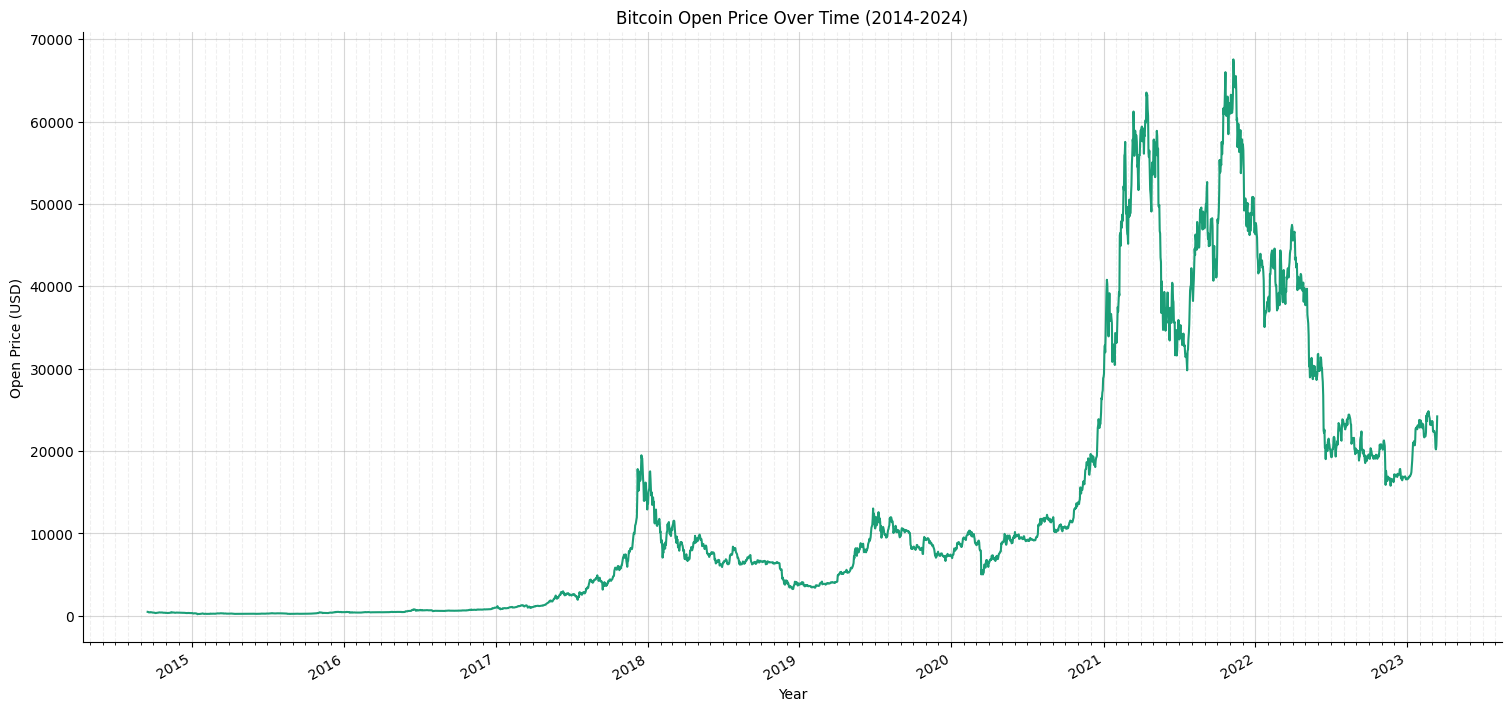

In [ ]:
maindf['Date'] = pd.to_datetime(maindf['Date'])

def _plot_series(series, series_name, series_index=0):
    palette = list(sns.palettes.mpl_palette('Dark2'))
    xs = series['Date']
    ys = series['Open']

    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(15, 7), layout='constrained')  # Using 'constrained' layout
df_sorted = maindf.sort_values('Date', ascending=True)
_plot_series(df_sorted, 'Bitcoin Open Price')

# Setting the x-axis to display dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator())

# Rotate and align the tick labels so they look better
for label in ax.get_xticklabels(which='major'):
    label.set_ha('right')
    label.set_rotation(30)

sns.despine(fig=fig, ax=ax)
plt.xlabel('Year')
plt.ylabel('Open Price (USD)')
plt.title('Bitcoin Open Price Over Time (2014-2024)')

# Add a grid for better readability
ax.grid(True, which='major', linestyle='-', alpha=0.5)
ax.grid(True, which='minor', linestyle='--', alpha=0.2)

# Instead of tight_layout(), we use the constrained layout
# plt.tight_layout()  # Removed this line to avoid warning

plt.show()

Plot number of Tweets vs Date

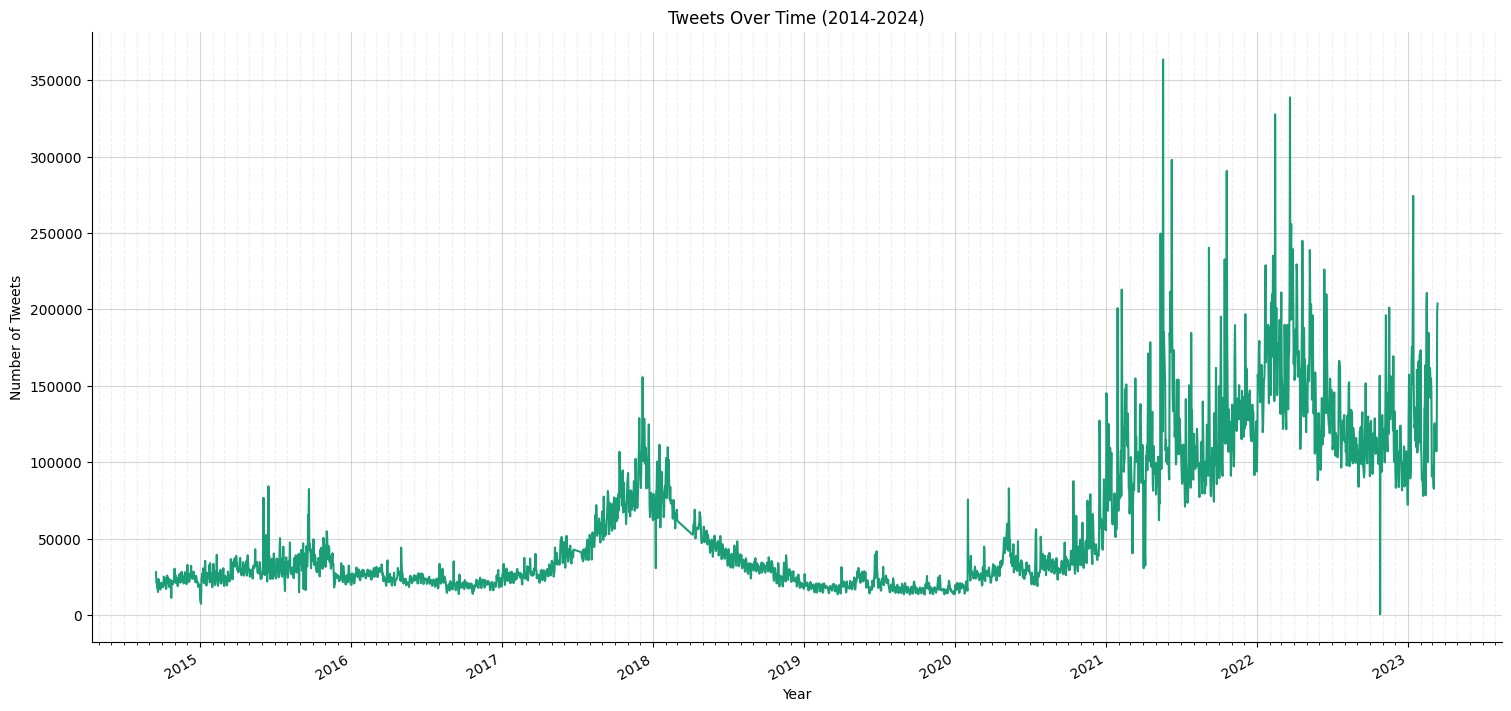

In [ ]:
# Define a function to plot a series against the Date column
def _plot_series(series, series_name, series_index=0):
    palette = list(sns.palettes.mpl_palette('Dark2'))
    xs = series['Date']
    ys = series['Tweets']

    plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

# Prepare the figure and axis for plotting
fig, ax = plt.subplots(figsize=(15, 7), layout='constrained')  # Using 'constrained' layout

# Sort the DataFrame by Date to ensure proper plotting
df_sorted = maindf.sort_values('Date', ascending=True)

# Plot the Tweets vs Date
_plot_series(df_sorted, 'Tweets Over Time')

# Format the x-axis to display dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator())

# Rotate and align the tick labels for readability
for label in ax.get_xticklabels(which='major'):
    label.set_ha('right')
    label.set_rotation(30)

# Add labels, title, and grid
sns.despine(fig=fig, ax=ax)
plt.xlabel('Year')
plt.ylabel('Number of Tweets')
plt.title('Tweets Over Time (2014-2024)')

# Add a grid for better readability
ax.grid(True, which='major', linestyle='-', alpha=0.5)
ax.grid(True, which='minor', linestyle='--', alpha=0.2)

# Display the plot
plt.show()


Plot open price and number of tweets vs date in the same graph

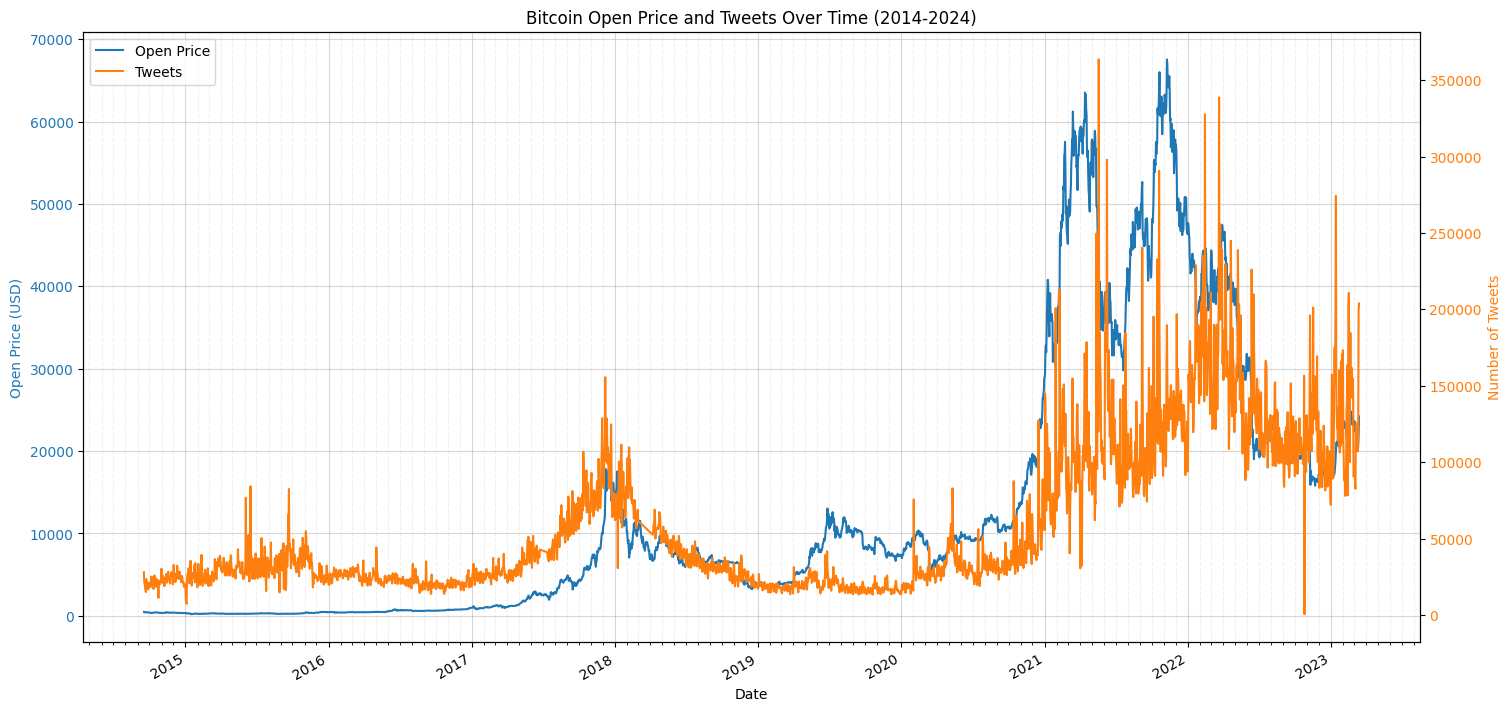

In [ ]:
fig, ax1 = plt.subplots(figsize=(15, 7), layout='constrained')  # Create the figure and first axis

# Plot Open Price on the primary Y-axis (left)
color_open = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Open Price (USD)', color=color_open)
ax1.plot(maindf['Date'], maindf['Open'], label='Open Price', color=color_open)
ax1.tick_params(axis='y', labelcolor=color_open)
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.xaxis.set_major_locator(mdates.YearLocator())
ax1.xaxis.set_minor_locator(mdates.MonthLocator())

# Create a secondary Y-axis (right) for Tweets
ax2 = ax1.twinx()
color_tweets = 'tab:orange'
ax2.set_ylabel('Number of Tweets', color=color_tweets)
ax2.plot(maindf['Date'], maindf['Tweets'], label='Tweets', color=color_tweets)
ax2.tick_params(axis='y', labelcolor=color_tweets)

# Add a title and grid
plt.title('Bitcoin Open Price and Tweets Over Time (2014-2024)')
ax1.grid(True, which='major', linestyle='-', alpha=0.5)
ax1.grid(True, which='minor', linestyle='--', alpha=0.2)

# Combine the legends of both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

# Rotate x-axis labels for better readability
for label in ax1.get_xticklabels(which='major'):
    label.set_ha('right')
    label.set_rotation(30)

# Show the plot
plt.show()
